In [13]:
from typing import Optional
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from rpy2 import robjects
from src.visualization import projection
from src.data import data_io

In [24]:
### Constants

COHORT = "CESC"
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim/TCGA"
EXTERNAL_DATA_DIR = DATA_DIR / "external"
EXTERNAL_DATA_DIR.mkdir(exist_ok=True, parents=True)
COUNTS_FILE = INTERIM_DATA_DIR / f"counts/{COHORT}.csv.gz"
if not COUNTS_FILE.exists():
    raise FileNotFoundError(
        f"{COUNTS_FILE} does not exist. Run `0_preprocess_and_label.ipynb` first."
    )
COLDATA_FILE = INTERIM_DATA_DIR / f"coldata/{COHORT}.csv"
assert COLDATA_FILE.exists()
FIGURES_DIR = Path("../reports/figures")
assert FIGURES_DIR.exists()
VST_DIR = INTERIM_DATA_DIR / "vst"
VST_DIR.mkdir(exist_ok=True, parents=True)

MSIGDB_URL_FMT = "https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName={geneset}&fileType=json"

## 1. Prep: Variance Stabilizing Transformation (VST)

In [ ]:
robjects.r('suppressPackageStartupMessages(library("src"))')
vst_transform = robjects.r["vst_transform"]
design_formula_cols = ["stage", "grade"]
vst_transform(str(COUNTS_FILE), str(COLDATA_FILE), str(VST_DIR), design_formula_cols)

In [15]:
vst_file = VST_DIR / f"{COHORT}.csv.gz"
vst_expr = pd.read_csv(vst_file, index_col=0)

## 2. Dimensionality Reduction: PCA and UMAP

In [16]:
def add_metadata(latent_df, coldata_df):
    """Add clinical attributes to a latent space dataframe to annotate it."""
    latent_df = latent_df.join(coldata_df)
    latent_df = latent_df.loc[latent_df["PT_resistant"].isin(("Yes", "No"))]
    latent_df["stage/grade"] = latent_df["stage"].str.cat(latent_df["grade"], sep="/")
    return latent_df

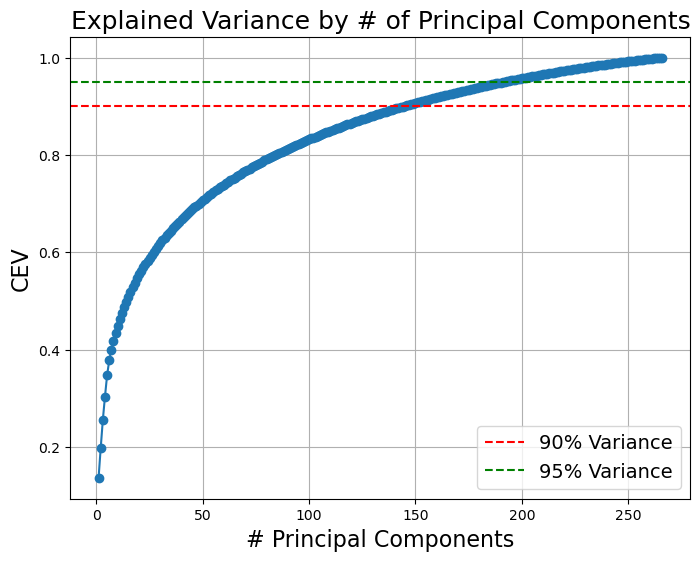

In [17]:
# Plot explained variance
projection.plot_explained_variance(vst_expr.T)

In [51]:
coldata = pd.read_csv(COLDATA_FILE, index_col=0)
assert np.all(vst_expr.columns == coldata.index)

n_components = 6
n_umap_dims = 3

pca = PCA(n_components=n_components)
pca_expr = pca.fit_transform(vst_expr.T)
pca_expr = pd.DataFrame(
    pca_expr, index=vst_expr.columns, columns=[f"PC-{i+1}" for i in range(n_components)]
)
explained_variance = pca.explained_variance_ratio_

umap_model = umap.UMAP(n_components=n_umap_dims, random_state=1)
umap_expr = umap_model.fit_transform(vst_expr.T)
umap_expr = pd.DataFrame(
    umap_expr,
    index=vst_expr.columns,
    columns=[f"UMAP-{i+1}" for i in range(n_umap_dims)],
)

pca_expr = add_metadata(pca_expr, coldata)
umap_expr = add_metadata(umap_expr, coldata)

/home/noah/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [52]:
pca_fig = projection.interactive_scatterplot(
    pca_expr,
    "stage/grade",
    "PT_resistant",
    n_components,
    title="3D PCA (Drag to rotate, scroll to zoom, ctrl+drag to pan)",
    explained_variance=explained_variance,
)
pca_fig.write_html(FIGURES_DIR / f"pca_{COHORT}.html")

In [53]:
umap_fig = projection.interactive_scatterplot(
    umap_expr, "stage/grade", "PT_resistant", n_umap_dims, title="3D UMAP"
)
umap_fig.write_html(FIGURES_DIR / f"umap_{COHORT}.html")

### Matrisome only

In [54]:
geneset = "NABA_MATRISOME"
geneset_url = MSIGDB_URL_FMT.format(geneset=geneset)
geneset_file = EXTERNAL_DATA_DIR / f"{geneset}.json"
data_io.download_file(MSIGDB_URL_FMT.format(geneset=geneset), geneset_file)

genes = pd.read_json(geneset_file).loc["geneSymbols"].tolist()[0]
genes_df = pd.read_csv(RAW_DATA_DIR / "genes.csv.gz", index_col=0)
genes_df = genes_df[genes_df["gene_name"].isin(genes)]
genes_df.index = genes_df.index.str.replace(r"\.\d+$", "", regex=True)
X = vst_expr[vst_expr.index.isin(genes_df.index)].T

n_components = 6
n_umap_dims = 3

pca = PCA(n_components=n_components)
pca_expr = pca.fit_transform(X)
pca_expr = pd.DataFrame(
    pca_expr, index=X.index, columns=[f"PC-{i+1}" for i in range(n_components)]
)
explained_variance = pca.explained_variance_ratio_

umap_model = umap.UMAP(n_components=n_umap_dims, random_state=1)
umap_expr = umap_model.fit_transform(X)
umap_expr = pd.DataFrame(
    umap_expr,
    index=X.index,
    columns=[f"UMAP-{i+1}" for i in range(n_umap_dims)],
)

pca_expr = add_metadata(pca_expr, coldata)
umap_expr = add_metadata(umap_expr, coldata)

X.shape

/home/noah/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



(266, 910)

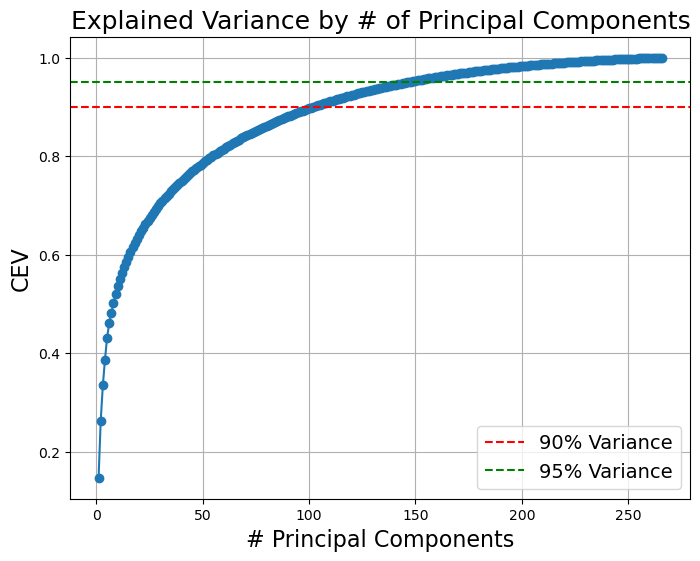

In [55]:
# Plot explained variance
projection.plot_explained_variance(X)

In [56]:
pca_fig = projection.interactive_scatterplot(
    pca_expr,
    "stage/grade",
    "PT_resistant",
    n_components,
    title="3D PCA (Matrisome genes)",
    explained_variance=explained_variance,
)
pca_fig.write_html(FIGURES_DIR / f"pca_matrisome_{COHORT}.html")

In [57]:
umap_fig = projection.interactive_scatterplot(
    umap_expr, "stage/grade", "PT_resistant", n_umap_dims, title="3D UMAP (Matrisome genes)"
)
umap_fig.write_html(FIGURES_DIR / f"umap_matrisome_{COHORT}.html")

### Core matrisome only

In [58]:
geneset = "NABA_CORE_MATRISOME"
geneset_url = MSIGDB_URL_FMT.format(geneset=geneset)
geneset_file = EXTERNAL_DATA_DIR / f"{geneset}.json"
data_io.download_file(MSIGDB_URL_FMT.format(geneset=geneset), geneset_file)

genes = pd.read_json(geneset_file).loc["geneSymbols"].tolist()[0]
genes_df = pd.read_csv(RAW_DATA_DIR / "genes.csv.gz", index_col=0)
genes_df = genes_df[genes_df["gene_name"].isin(genes)]
genes_df.index = genes_df.index.str.replace(r"\.\d+$", "", regex=True)
X = vst_expr[vst_expr.index.isin(genes_df.index)].T

n_components = 6
n_umap_dims = 3

pca = PCA(n_components=n_components)
pca_expr = pca.fit_transform(X)
pca_expr = pd.DataFrame(
    pca_expr, index=X.index, columns=[f"PC-{i+1}" for i in range(n_components)]
)
explained_variance = pca.explained_variance_ratio_

umap_model = umap.UMAP(n_components=n_umap_dims, random_state=1)
umap_expr = umap_model.fit_transform(X)
umap_expr = pd.DataFrame(
    umap_expr,
    index=X.index,
    columns=[f"UMAP-{i+1}" for i in range(n_umap_dims)],
)

pca_expr = add_metadata(pca_expr, coldata)
umap_expr = add_metadata(umap_expr, coldata)

X.shape

/home/noah/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



(266, 255)

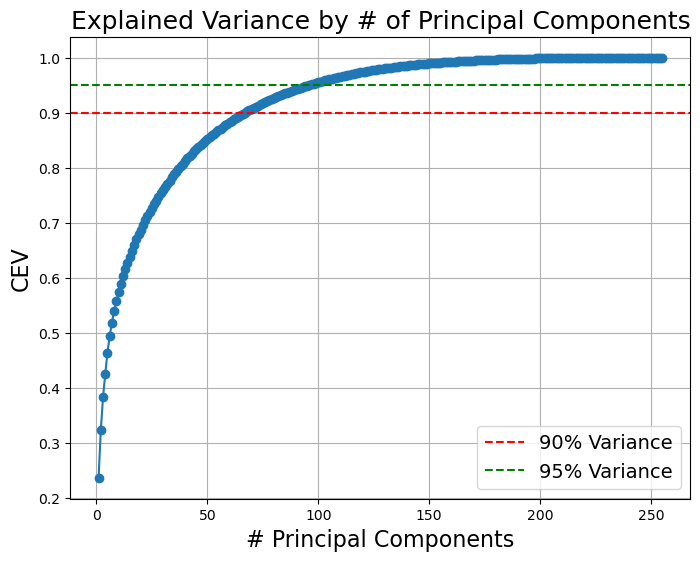

In [59]:
# Plot explained variance
projection.plot_explained_variance(X)

In [60]:
pca_fig = projection.interactive_scatterplot(
    pca_expr,
    "stage/grade",
    "PT_resistant",
    n_components,
    title="3D PCA (Core Matrisome genes)",
    explained_variance=explained_variance,
)
pca_fig.write_html(FIGURES_DIR / f"pca_core_matrisome_{COHORT}.html")

In [61]:
umap_fig = projection.interactive_scatterplot(
    umap_expr, "stage/grade", "PT_resistant", n_umap_dims, title="3D UMAP (Core Matrisome genes)"
)
umap_fig.write_html(FIGURES_DIR / f"umap_core_matrisome_{COHORT}.html")